<a href="https://colab.research.google.com/github/agalvezm/ACE2_scRNAseq/blob/master/notebooks_countmatrices/template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#McCauley et al 2018, Figure 6D reanalysis
Test analysis of sample "Distal" of the dataset [GSE103918](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE103918) from the [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5995784/) *Single-Cell Transcriptomic Profiling of Pluripotent Stem Cell-Derived SCGB3A2+ Airway Epithelium*. The results derived from this dataset appear in *Fig 6D* of the paper.

#Obtaining count matrices

## Installing kb and scanpy

In [ ]:
 # Install kb.
!pip -q install kb-python 
!pip -q install scanpy

     |████████████████████████████████| 35.4MB 120kB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 122kB 50.4MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 7.7MB 7.5MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 


## Downloading bam file and converting it to fastq

In [ ]:
# Install bamtofastq from 10x website (only bam files available)
!wget http://cf.10xgenomics.com/misc/bamtofastq-1.2.0
!chmod +x bamtofastq-1.2.0

--2020-09-01 19:54:55--  http://cf.10xgenomics.com/misc/bamtofastq-1.2.0
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/misc/bamtofastq-1.2.0 [following]
--2020-09-01 19:54:55--  https://cf.10xgenomics.com/misc/bamtofastq-1.2.0
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13288280 (13M) [binary/octet-stream]
Saving to: ‘bamtofastq-1.2.0’

bamtofastq-1.2.0    100%[===================>]  12.67M  9.53MB/s    in 1.3s    

2020-09-01 19:54:57 (9.53 MB/s) - ‘bamtofastq-1.2.0’ saved [13288280/13288280]



In [ ]:
# Download the bam file
!wget -- continue ftp://ftp.sra.ebi.ac.uk/vol1/SRA608/SRA608611/bam/distal_possorted_genome_bam.bam

--2020-09-01 19:54:57--  http://continue/
Resolving continue (continue)... failed: Name or service not known.
wget: unable to resolve host address ‘continue’
--2020-09-01 19:54:57--  ftp://ftp.sra.ebi.ac.uk/vol1/SRA608/SRA608611/bam/distal_possorted_genome_bam.bam
           => ‘distal_possorted_genome_bam.bam’
Resolving ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)|193.62.193.138|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /vol1/SRA608/SRA608611/bam ... done.
==> SIZE distal_possorted_genome_bam.bam ... 17847518192
==> PASV ... done.    ==> RETR distal_possorted_genome_bam.bam ... done.
Length: 17847518192 (17G) (unauthoritative)

distal_possorted_ge  14%[=>                  ]   2.38G  4.32MB/s    in 19m 5s  

2020-09-01 20:14:15 (2.13 MB/s) - Control connection closed.
Retrying.

--2020-09-01 20:29:16--  ftp://ftp.sra.ebi.ac.uk/vol1/SRA6

In [ ]:
# Convert to fastq
!./bamtofastq-1.2.0 --reads-per-fastq=500000000 distal_possorted_genome_bam.bam ./fastqs

bamtofastq v1.2.0
Args { arg_bam: "distal_possorted_genome_bam.bam", arg_output_path: "./fastqs", flag_nthreads: 4, flag_locus: None, flag_bx_list: None, flag_reads_per_fastq: 500000000, flag_gemcode: false, flag_lr20: false, flag_cr11: false }
Writing finished.  Observed 184823493 read pairs. Wrote 184823493 read pairs


In [ ]:
# Remove original bam file to save space
!rm distal_possorted_genome_bam.bam

## Run Kallisto

In [ ]:
# Download the mouse Kallisto index
!kb ref -d human -i index.idx -g t2g.txt -f1 transcriptome.fasta

[2020-09-01 22:23:06,654]    INFO Downloading files for human from https://caltech.box.com/shared/static/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz to tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz
[2020-09-01 22:26:33,243]    INFO Extracting files from tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz


In [ ]:
# Pseudoalignment and counting
!kb count --h5ad -i index.idx -g t2g.txt -x 10xv2 -o output --filter bustools -t 2 --overwrite \
fastqs/distal_MissingLibrary_1_HVNYNBGX2/bamtofastq_S1_L001_R1_001.fastq.gz \
fastqs/distal_MissingLibrary_1_HVNYNBGX2/bamtofastq_S1_L001_R2_001.fastq.gz \
fastqs/distal_MissingLibrary_1_HVNYNBGX2/bamtofastq_S1_L002_R1_001.fastq.gz \
fastqs/distal_MissingLibrary_1_HVNYNBGX2/bamtofastq_S1_L002_R2_001.fastq.gz \
fastqs/distal_MissingLibrary_1_HVNYNBGX2/bamtofastq_S1_L003_R1_001.fastq.gz \
fastqs/distal_MissingLibrary_1_HVNYNBGX2/bamtofastq_S1_L003_R2_001.fastq.gz \
fastqs/distal_MissingLibrary_1_HVNYNBGX2/bamtofastq_S1_L004_R1_001.fastq.gz \
fastqs/distal_MissingLibrary_1_HVNYNBGX2/bamtofastq_S1_L004_R2_001.fastq.gz



[2020-09-01 22:27:11,948]    INFO Generating BUS file from
[2020-09-01 22:27:11,948]    INFO         fastqs/distal_MissingLibrary_1_HVNYNBGX2/bamtofastq_S1_L001_R1_001.fastq.gz
[2020-09-01 22:27:11,949]    INFO         fastqs/distal_MissingLibrary_1_HVNYNBGX2/bamtofastq_S1_L001_R2_001.fastq.gz
[2020-09-01 22:27:11,949]    INFO         fastqs/distal_MissingLibrary_1_HVNYNBGX2/bamtofastq_S1_L002_R1_001.fastq.gz
[2020-09-01 22:27:11,949]    INFO         fastqs/distal_MissingLibrary_1_HVNYNBGX2/bamtofastq_S1_L002_R2_001.fastq.gz
[2020-09-01 22:27:11,949]    INFO         fastqs/distal_MissingLibrary_1_HVNYNBGX2/bamtofastq_S1_L003_R1_001.fastq.gz
[2020-09-01 22:27:11,949]    INFO         fastqs/distal_MissingLibrary_1_HVNYNBGX2/bamtofastq_S1_L003_R2_001.fastq.gz
[2020-09-01 22:27:11,949]    INFO         fastqs/distal_MissingLibrary_1_HVNYNBGX2/bamtofastq_S1_L004_R1_001.fastq.gz
[2020-09-01 22:27:11,949]    INFO         fastqs/distal_MissingLibrary_1_HVNYNBGX2/bamtofastq_S1_L004_R2_001.fastq.

## Load the unfiltered matrix

In [ ]:
# Setup

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [ ]:
# load the unfiltered matrix
adata = anndata.read_h5ad("output/counts_unfiltered/adata.h5ad")
adata.var["gene_id"] = adata.var.index.values

t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
adata.var.index = adata.var["gene_name"]
print("The unfiltered matrix contains {} cells by {} genes".format(len(adata.obs), len(adata.var)))

The unfiltered matrix contains 216390 cells by 60623 genes


# Populate the Anndata object 

In [ ]:
# Parameter settings we use throughout the notebook

num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 50
num_NCA = 10

# Filtering criteria
cell_threshold = 100
gene_threshold = 3

mito_criteria = 30

n_top_genes = 5000

n_bins = 20

flavor="seurat"

In [ ]:
adata.obs["cell_counts"] = adata.X.sum(axis=1)
adata.var["gene_counts"] = nd(adata.X.sum(axis=0))

adata.obs["n_genes"] = nd((adata.X>0).sum(axis=1))
adata.var["n_cells"] = nd((adata.X>0).sum(axis=0))

mito_genes = adata.var_names.str.startswith("MT-" or "mt-") 
adata.obs["percent_mito"] = adata[:,mito_genes].X.sum(axis=1)/adata.X.sum(axis=1)*100

## Filter by low UMIs

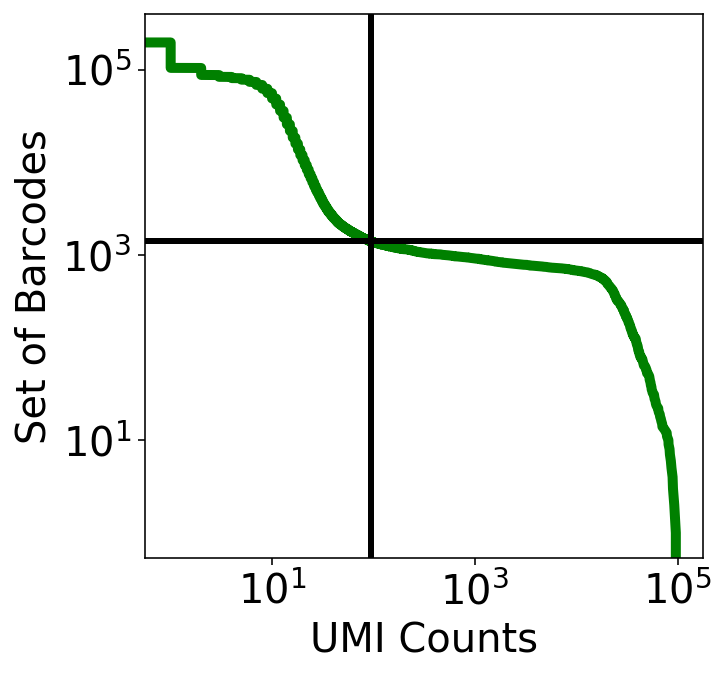

In [ ]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
expected_num_cells = 1400#@param {type:"integer"}
knee = np.sort(nd(adata.X.sum(axis=1)))[::-1]

fig, ax = plt.subplots(figsize=(5, 5))

x = knee
y = range(len(knee))

ax.loglog(x, y, linewidth=5, color="g")

ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.show()

We choose 1400 as the threshold

## Filter by mitochondrial content

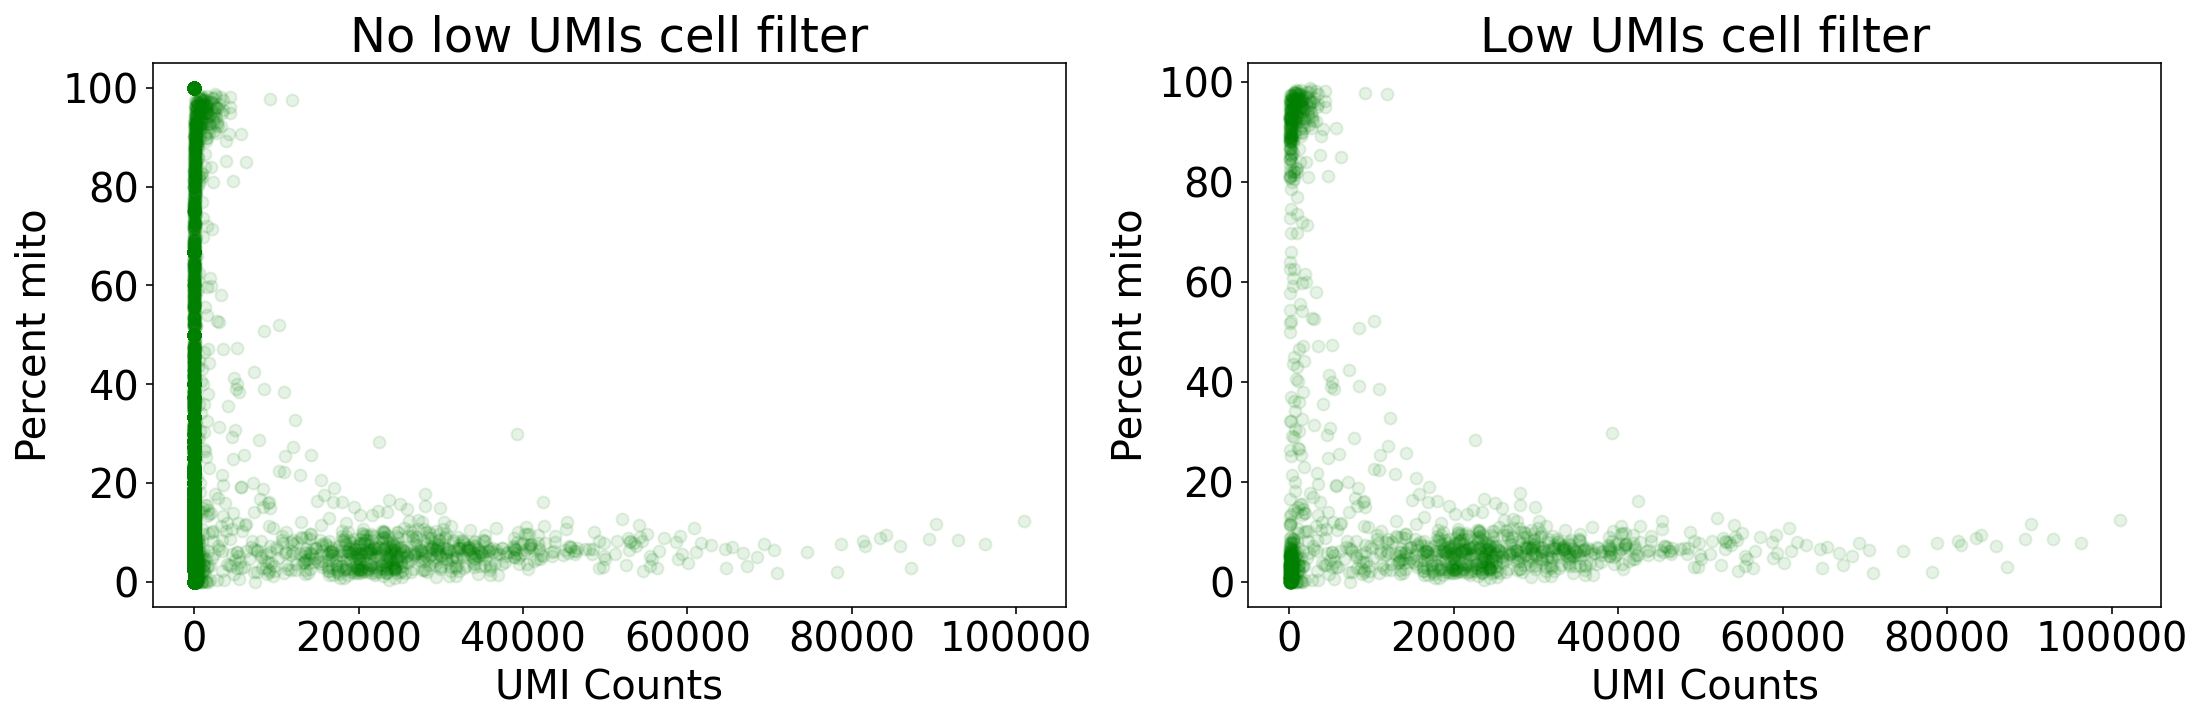

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(18,5), ncols = 2)

x = nd(adata.obs["cell_counts"])
y = nd(adata.obs["percent_mito"])

x_2 = nd(adata.obs["cell_counts"][adata.obs["cell_counts"] > cell_threshold])
y_2 = nd(adata.obs["percent_mito"][adata.obs["cell_counts"] > cell_threshold])

ax1.scatter(x, y, color="green", alpha=0.1)
ax2.scatter(x_2, y_2, color="green", alpha=0.1)

ax.axhline(y=mito_criteria, linestyle="--", color="k")

ax1.set_xlabel("UMI Counts")
ax1.set_ylabel("Percent mito")

ax2.set_xlabel("UMI Counts")
ax2.set_ylabel("Percent mito")

ax1.set_title("No low UMIs cell filter")
ax2.set_title("Low UMIs cell filter")

plt.show()

We choose 30% as our mitochondrial content threshold based on the plot.

# Filter the Ann data object

In [ ]:
adata.obs["pass_count_filter"] = adata.obs["cell_counts"] > cell_threshold
adata.obs["pass_mito_filter"] = adata.obs.percent_mito < mito_criteria
adata.var["pass_gene_filter"] = adata.var["n_cells"] > gene_threshold

In [ ]:
cell_mask = np.logical_and(adata.obs["pass_count_filter"].values, adata.obs["pass_mito_filter"].values)
gene_mask = adata.var["pass_gene_filter"].values

In [ ]:
print("Current Shape: {:,} cells x {:,} genes".format(adata.shape[0], adata.shape[1]))
print("    New shape: {:,} cells x {:,} genes".format(cell_mask.sum(), gene_mask.sum()))

Current Shape: 216,390 cells x 60,623 genes
    New shape: 1,068 cells x 26,839 genes


In [ ]:
data = adata[cell_mask, gene_mask]

# Library saturation

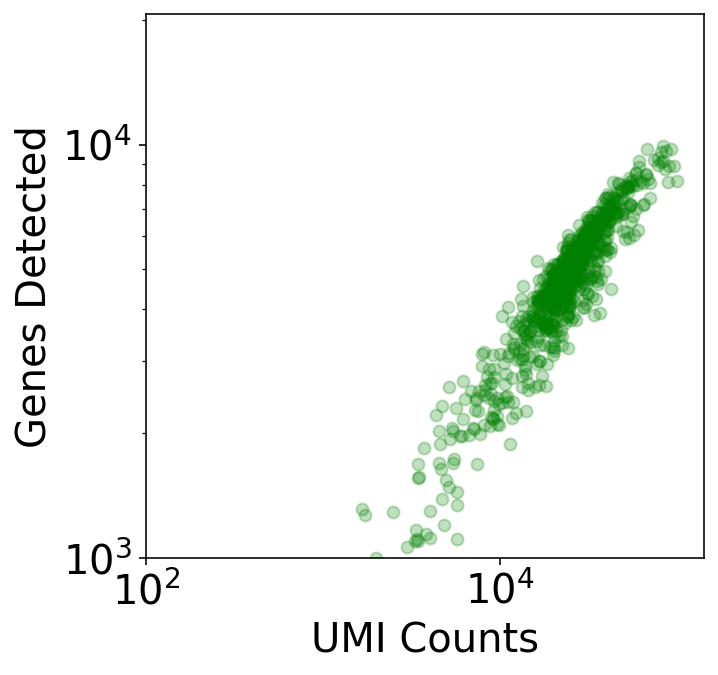

In [ ]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(5, 5))

x = nd(data.X.sum(axis=1))
y = nd(np.sum(data.X>0, axis=1))

ax.scatter(x, y, color="green", alpha=0.25)

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(10**2)
ax.set_ylim(10**3, 12**4)

plt.show()

# Analysis

Show those genes that yield the highest fraction of counts across cells.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


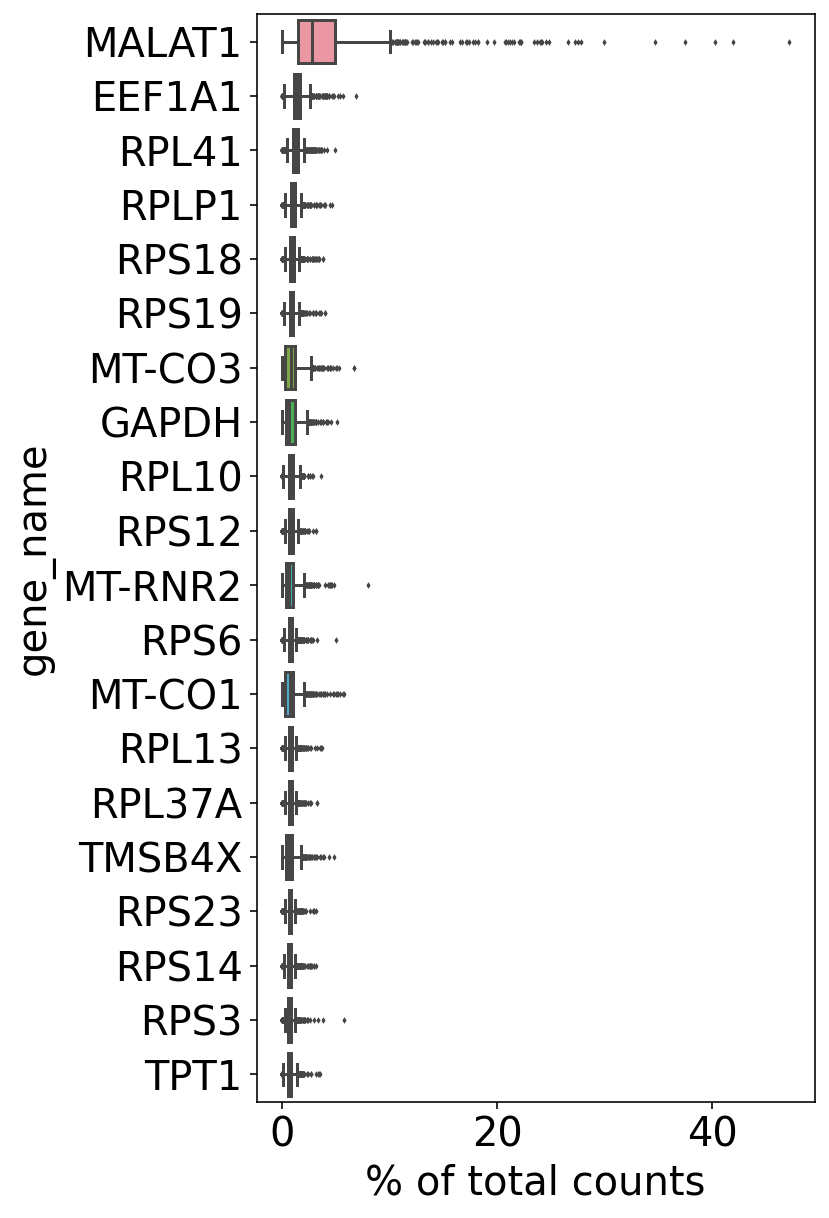

In [ ]:
fig, ax = plt.subplots(figsize=(5, 10))
sc.pl.highest_expr_genes(data, n_top=20, ax = ax)

This is somewhat surprising. MALT1 is a lung cancer biomarker. The original paper does not mention it and I havent found any reference about its high expression in the healthy lung.

In [ ]:
# setup

def vplot(y, ax):
    parts = ax.violinplot(
        y, showmeans=False, showmedians=False,
        showextrema=False)

    mean = y.mean()
    ax.scatter(1, mean, zorder=10, color="white")
    
    x = np.random.normal(1, 0.04, size=len(y))
    ax.scatter(x, y, color="k", s=1)
    
    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
    ax.set_xticks([1])
    ax.set_xticklabels([""])
    return ax
  
!pip3 install leidenalg

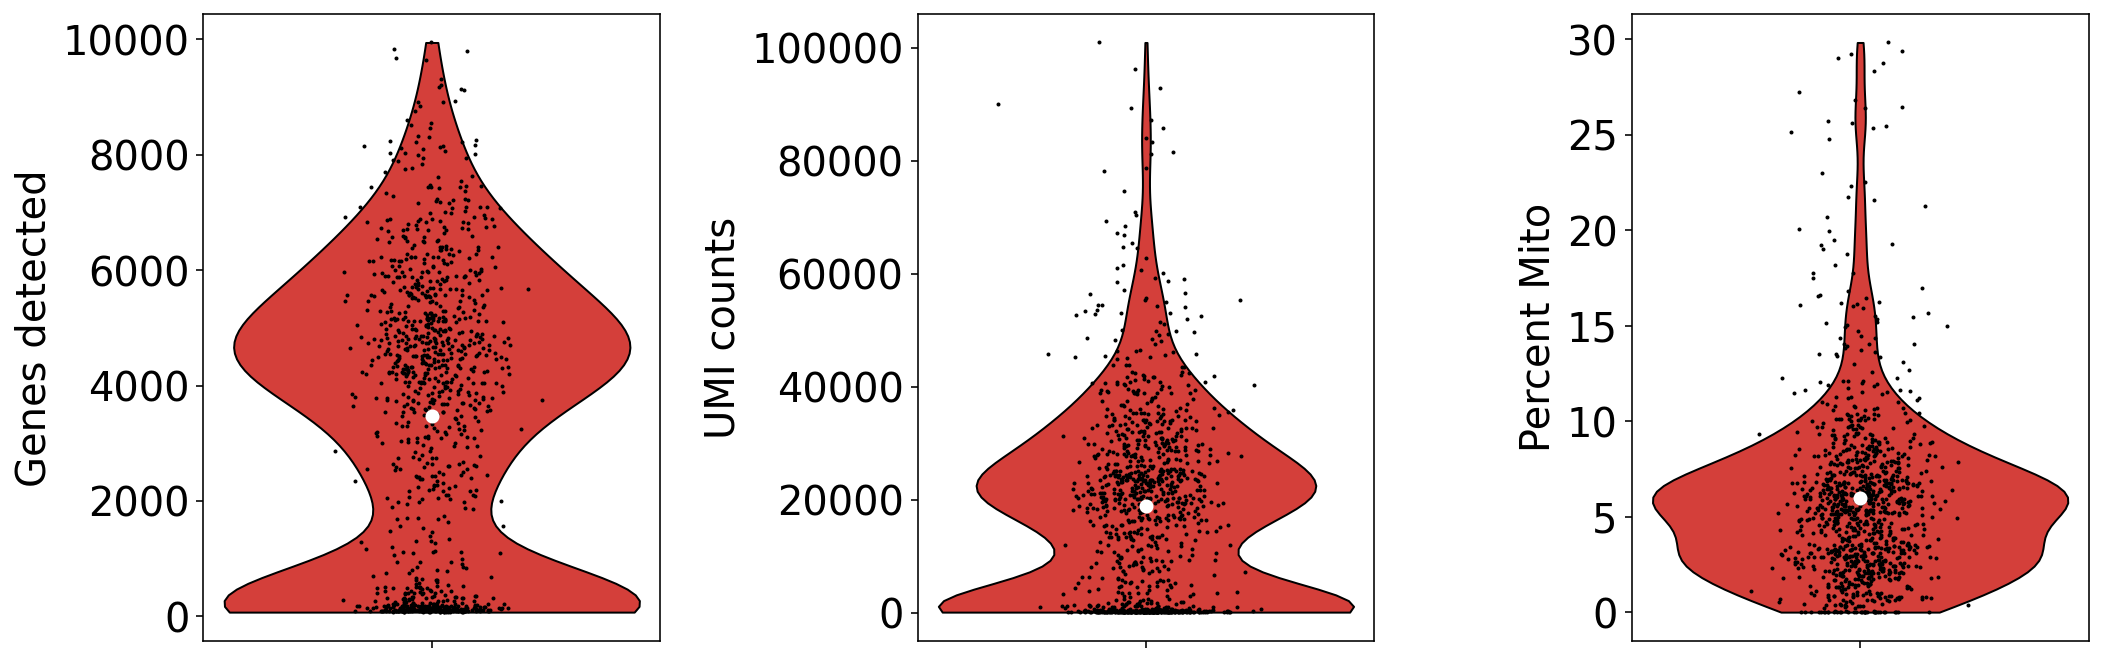

In [ ]:
fig, ax = plt.subplots(figsize=(5*3,5), ncols=3)

x1 = data.obs["n_genes"]
x2 = nd(data.X.sum(axis=1))
x3 = data.obs["percent_mito"]

vplot(x1, ax[0])
vplot(x2, ax[1])
vplot(x3, ax[2])

ax[0].set_ylabel("Genes detected")
ax[1].set_ylabel("UMI counts")
ax[2].set_ylabel("Percent Mito")

plt.tight_layout()
plt.show()

It looks like a lot of genes were detected in the cells of this sample (compared to [mouse_lung.ipynb](https://colab.research.google.com/github/pachterlab/BBB/blob/master/notebooks/lung_atlas/mouse_lung_dropseq_SRR8426358_python.ipynb#scrollTo=hunZWpAKVOV8))

# Process the matrix for clustering, visualization, and DE (normalization, log1p transformation, scaling)

The commands below convert the counts into *CPM* units. This stands for "counts per million". In each cell the counts are normalized by the total number of reads in each cell. `log1p` is the function log1p(x) = log(x+1).

In [ ]:
# Create a layer with the raw, original data
data.layers["raw"] = data.X

In [ ]:
# Create another layer "norm" with normalized data (counts per scale_num, i.e. per million)
scale_num = 1000000
data.layers["norm"] = normalize(data.X, norm="l1", axis=1)*scale_num

In [ ]:
# Create the "log1p" layer with the log1p converted values
data.layers["log1p"] = np.log1p(data.layers["norm"])
data.uns = OrderedDict([("log1p", {"base":None})])

In [ ]:
# Replace original, raw data of matrix X with the normalized and log1p converted data.
data.X = data.layers["log1p"]

Detecting highly variable genes is done on the log1p(norm) data. We will do PCA on these genes in a posterior step.

In [ ]:
sc.pp.highly_variable_genes(data, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = data.var.highly_variable.values

Now we scale the columns of the matrix to unit variance and zero mean

In [ ]:
%%time
# Scaling operation cannot be performed on the sparse matrix, so we make a dense matrix
mat = data.layers["log1p"].todense()

# Create new layer with scaled data
data.layers["scale"] = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)

# Replace matrix X with the normalized, log1p transformed and scaled data
data.X = data.layers["scale"]

del mat

CPU times: user 997 ms, sys: 25.9 ms, total: 1.02 s
Wall time: 1.02 s


# Generating visualizations

## PCA on highly variable genes

In [ ]:
%%time
# PCA
X = data.X[:,hvg_mask]

tsvd = TruncatedSVD(n_components=num_PCA)
data.obsm["X_pca"] = tsvd.fit_transform(X)

CPU times: user 860 ms, sys: 86.2 ms, total: 946 ms
Wall time: 522 ms


## Clustering

In [ ]:
sc.pp.neighbors(data, n_neighbors=n_neighbors, n_pcs=num_PCA, random_state=state)

In [ ]:
sc.tl.leiden(data, random_state=state)

In [ ]:
# t-SNE
X = data.obsm["X_pca"]

tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
data.obsm["X_pca_tsne"] = tsne.fit_transform(X)

In [ ]:
# NCA
X = data.X
y = data.obs.leiden.values # you could use louvain here also

nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
data.obsm["X_nca"] = nca.fit_transform(X, y)

In [ ]:
# t-SNE the NCA projection
X = data.obsm["X_nca"]
tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
data.obsm["X_nca_tsne"] = tsne.fit_transform(X)

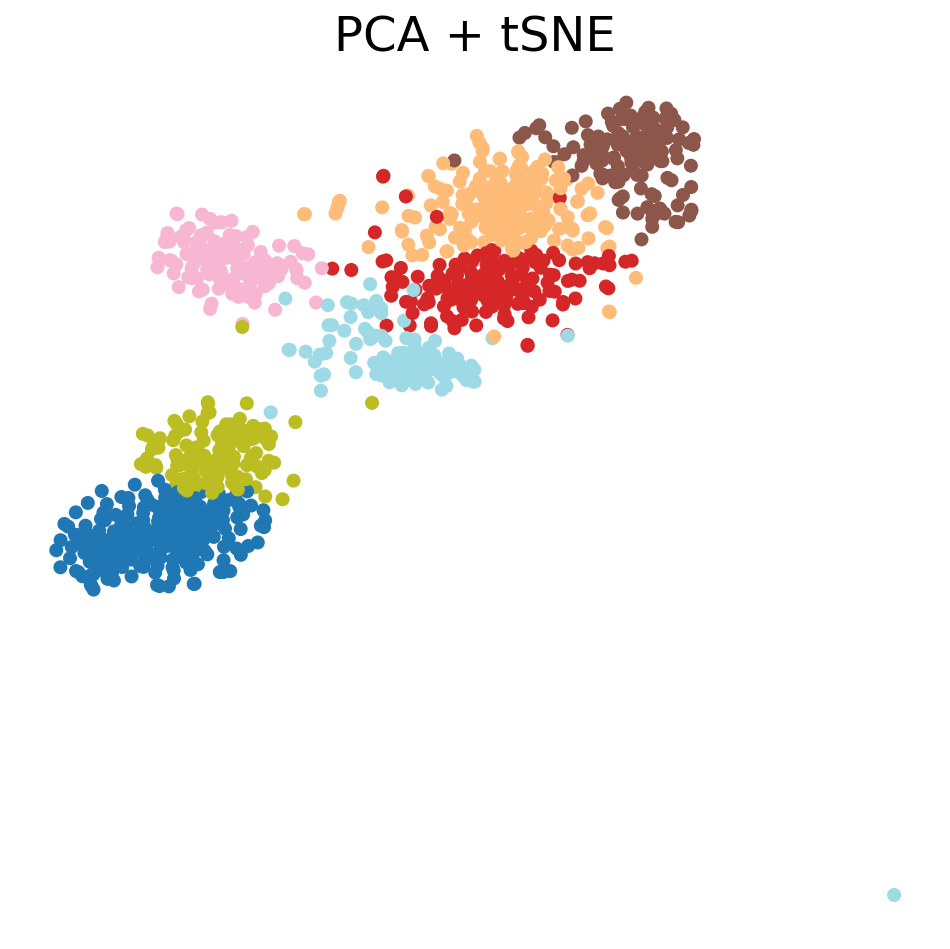

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_pca_tsne"][:,0]
y = data.obsm["X_pca_tsne"][:,1]
c = data.obs["leiden"].astype(int)

ax.scatter(x, y, c = c, cmap='tab20')

ax.set_axis_off()

ax.set_title("PCA + tSNE")

plt.tight_layout()
plt.show()

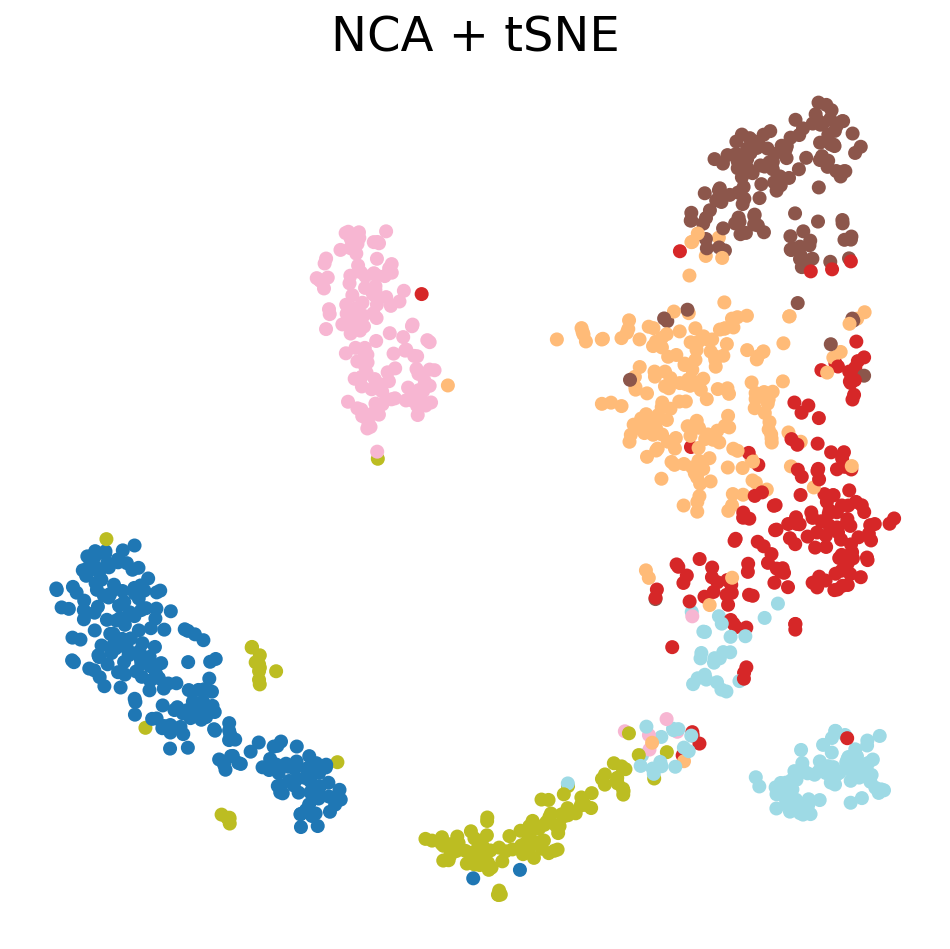

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_nca_tsne"][:,0]
y = data.obsm["X_nca_tsne"][:,1]
c = data.obs["leiden"].astype(int)

ax.scatter(x, y, c = c, cmap='tab20')

ax.set_axis_off()

ax.set_title("NCA + tSNE")


plt.tight_layout()
plt.show()

## Find marker genes

We will use the non-parametric [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test.

... storing 'gene_name' as categorical


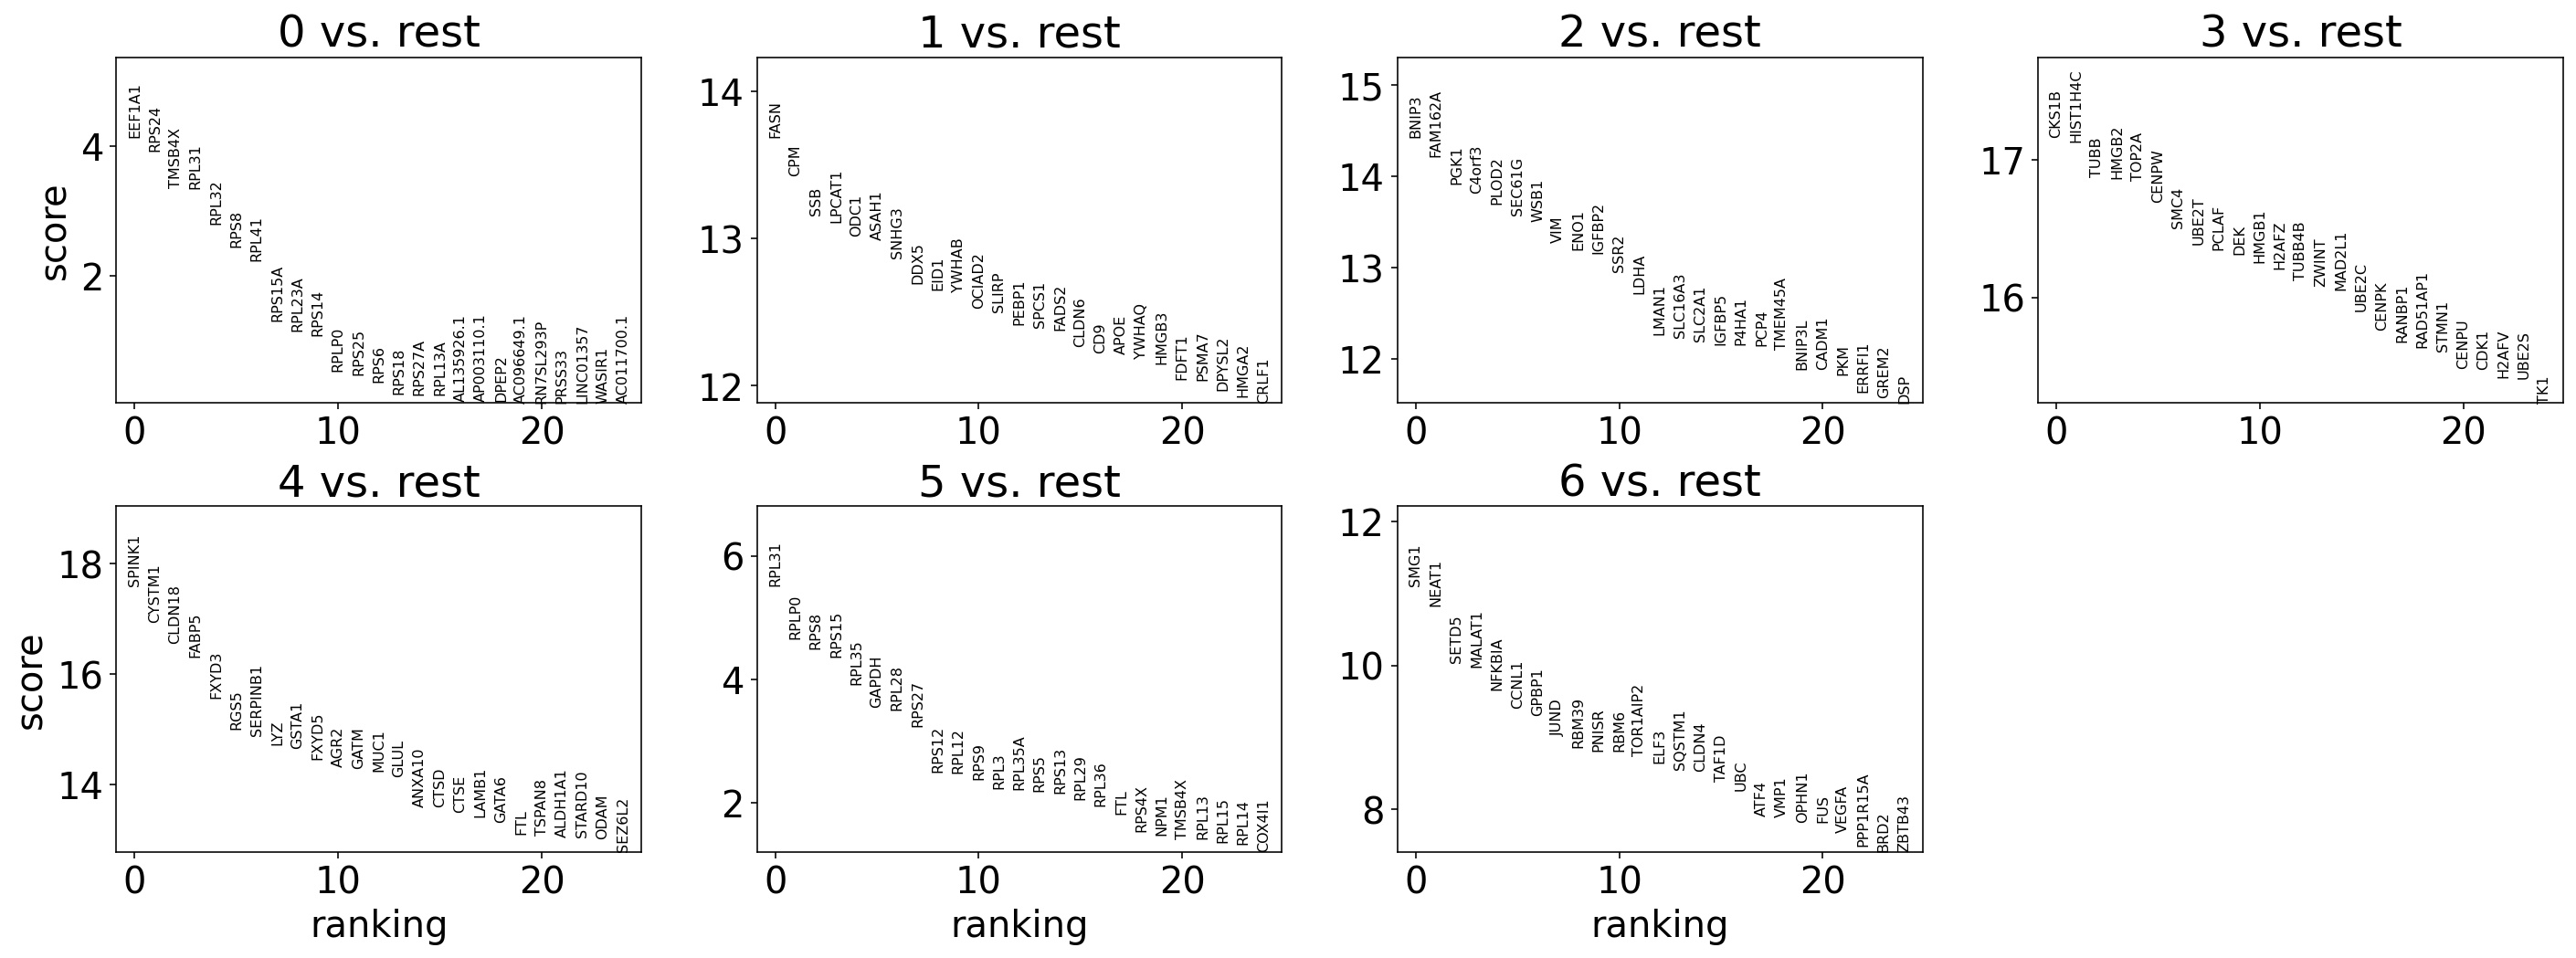

In [ ]:
sc.tl.rank_genes_groups(data, 'leiden', method='wilcoxon', corr_method="bonferroni")
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

Show the 10 top ranked genes per cluster in a dataframe.

In [ ]:
pd.DataFrame(data.uns['rank_genes_groups']['names']).head(10)

,0,1,2,3,4,5,6
0,EEF1A1,FASN,BNIP3,CKS1B,SPINK1,RPL31,SMG1
1,RPS24,CPM,FAM162A,HIST1H4C,CYSTM1,RPLP0,NEAT1
2,TMSB4X,SSB,PGK1,TUBB,CLDN18,RPS8,SETD5
3,RPL31,LPCAT1,C4orf3,HMGB2,FABP5,RPS15,MALAT1
4,RPL32,ODC1,PLOD2,TOP2A,FXYD3,RPL35,NFKBIA
5,RPS8,ASAH1,SEC61G,CENPW,RGS5,GAPDH,CCNL1
6,RPL41,SNHG3,WSB1,SMC4,SERPINB1,RPL28,GPBP1
7,RPS15A,DDX5,VIM,UBE2T,LYZ,RPS27,JUND
8,RPL23A,EID1,ENO1,PCLAF,GSTA1,RPS12,RBM39
9,RPS14,YWHAB,IGFBP2,DEK,FXYD5,RPL12,PNISR


Create a table with the marker genes, p-values, clusters.

In [ ]:
genes = pd.DataFrame(data.uns['rank_genes_groups']['names']).to_numpy()
pvals = pd.DataFrame(data.uns['rank_genes_groups']['pvals']).to_numpy()

In [ ]:
unique = np.unique(data.obs.leiden.values.astype(int)).astype(str)
markers_gene = pd.DataFrame(index=unique, columns=["gene_name", "p_value"])

In [ ]:
for un, u in enumerate(unique):
    g = genes[:,un]
    p = pvals[:,un]
    markers_gene.loc[u]["gene_name"]  = g.tolist()
    markers_gene.loc[u]["p_value"] = p.tolist()

In [ ]:
markers_gene = markers_gene.apply(pd.Series.explode).reset_index()
markers_gene = markers_gene.rename(columns={"index":'leiden'})

In [ ]:
markers_gene.drop_duplicates(["leiden"]) # just showing the top candidate per cluster

,leiden,gene_name,p_value
0,0,EEF1A1,3.41251e-05
26839,1,FASN,1.20363e-42
53678,2,BNIP3,3.29412e-47
80517,3,CKS1B,4.90443e-66
107356,4,SPINK1,2.58924e-69
134195,5,RPL31,3.57297e-08
161034,6,SMG1,1.19217e-28


# Clusters described in Figure 6D: comparison to original publication.

The paper uses specific cell-types markers to define clusters identities.  We will visualize the expression of such markers in the different clusters as described in [Figure 6D](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5995784/figure/fig6/). Note that we are only analyzing the distal media cells in this notebook.




The first cluster we will discuss is that of **gastric cells (C3 in the paper)**. These are contaminant, non-lung cells that appear in the analysis.
These cells are characterized by: 

1.   Low expression of NKX2-1
2.   High expression of TFF1

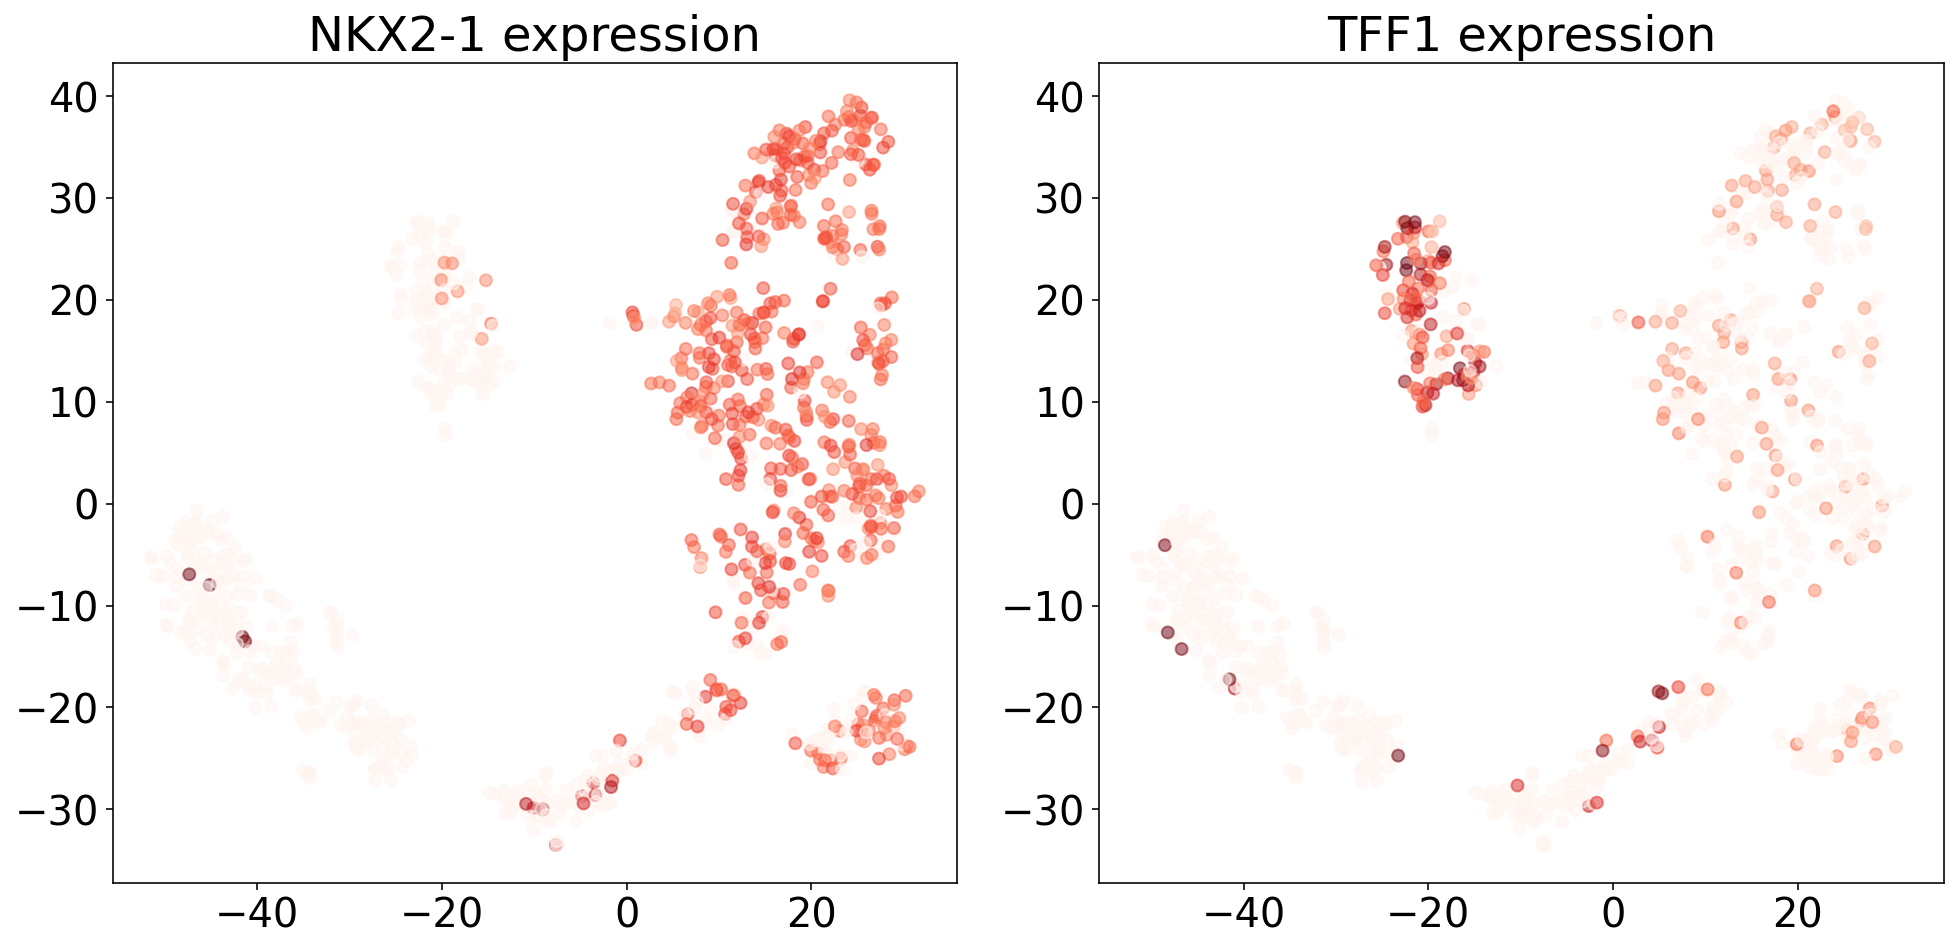

In [ ]:
gene1 = "NKX2-1"
gene2 = "TFF1"
fig, (ax1, ax2) = plt.subplots(figsize=(14,7), ncols = 2)

x = data.obsm["X_nca_tsne"][:,0]
y = data.obsm["X_nca_tsne"][:,1]
c1 = nd(data.layers["log1p"].todense()[:,data.var.gene_name==gene1])
c2 = nd(data.layers["log1p"].todense()[:,data.var.gene_name==gene2])


ax1.scatter(x, y, c = c1, cmap='Reds', alpha=0.5)
ax2.scatter(x, y, c = c2, cmap='Reds', alpha=0.5)

ax.set_axis_off()
ax1.set_title("{} expression".format(gene1))
ax2.set_title("{} expression".format(gene2))
plt.tight_layout()
plt.show()

As can be seen, the middle cluster corresponds to gastric cells, reproducing the results in the paper.

**Clusters 1 and 2 (AEC2 and AEC2 mitotic cells)** express FOXP2 , but only cluster 2 expresses AURKB







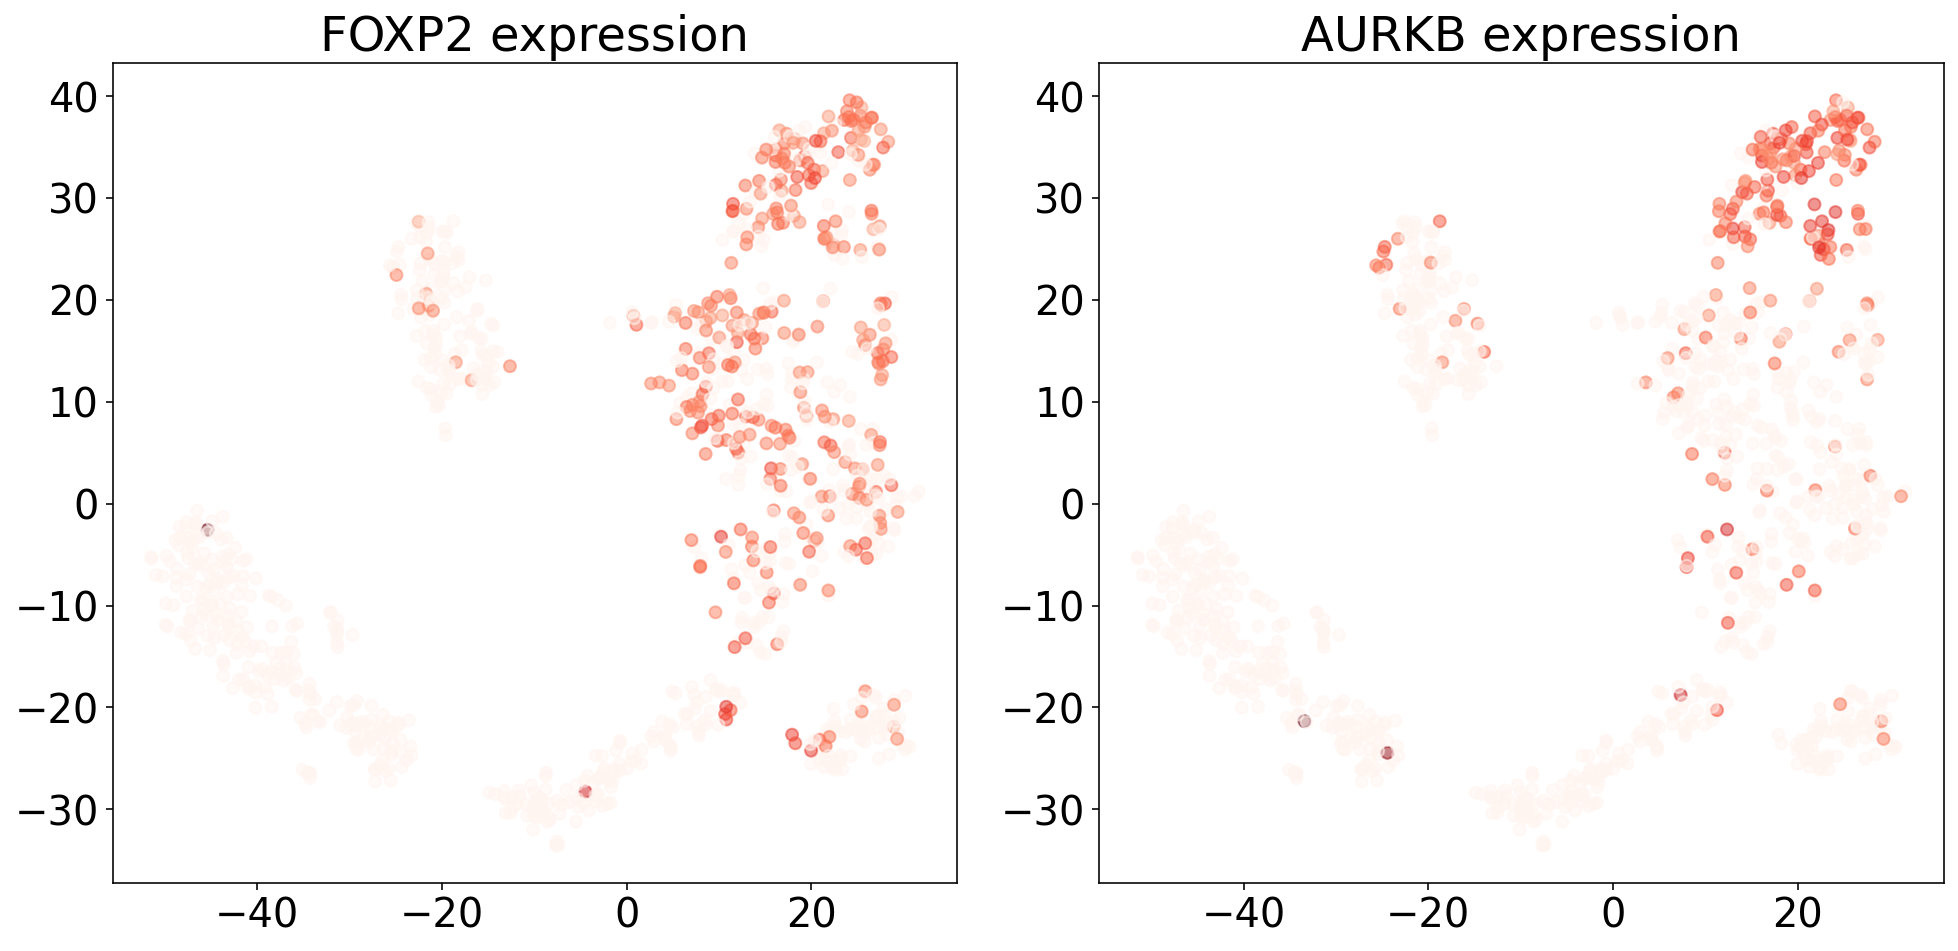

In [ ]:
gene1 = "FOXP2"
gene2 = "AURKB"
fig, (ax1, ax2) = plt.subplots(figsize=(14,7), ncols = 2)

x = data.obsm["X_nca_tsne"][:,0]
y = data.obsm["X_nca_tsne"][:,1]
c1 = nd(data.layers["log1p"].todense()[:,data.var.gene_name==gene1])
c2 = nd(data.layers["log1p"].todense()[:,data.var.gene_name==gene2])


ax1.scatter(x, y, c = c1, cmap='Reds', alpha=0.5)
ax2.scatter(x, y, c = c2, cmap='Reds', alpha=0.5)

ax.set_axis_off()
ax1.set_title("{} expression".format(gene1))
ax2.set_title("{} expression".format(gene2))
plt.tight_layout()
plt.show()

These results match the ones reported in the paper.


Finally, **cluster 7 (AEC2-like cells)** are characterized by absence of SFTPC expression, which corresponds to the cluster at the very top.

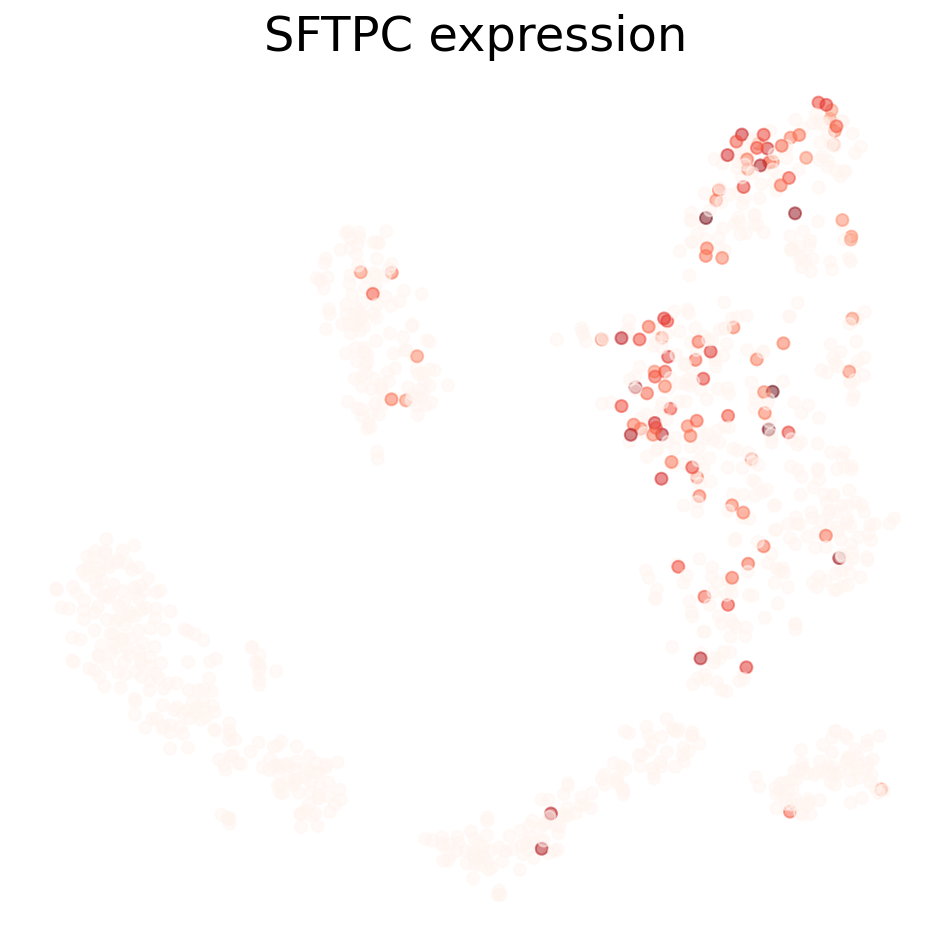

In [ ]:
gene = "SFTPC"

fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_nca_tsne"][:,0]
y = data.obsm["X_nca_tsne"][:,1]
c = nd(data.layers["log1p"].todense()[:,data.var.gene_name==gene])

ax.scatter(x, y, c = c, cmap='Reds', alpha=0.5)

ax.set_axis_off()
ax.set_title("{} expression".format(gene))
plt.tight_layout()
plt.show()

As can be seen, one of the clusters do not show significant expression of SFTPC. This analysis shows that we can reproduce the results in the paper.



# ACE2 expression

When we try to make an equivalent plot for ACE2, we observe no expression in any cell:

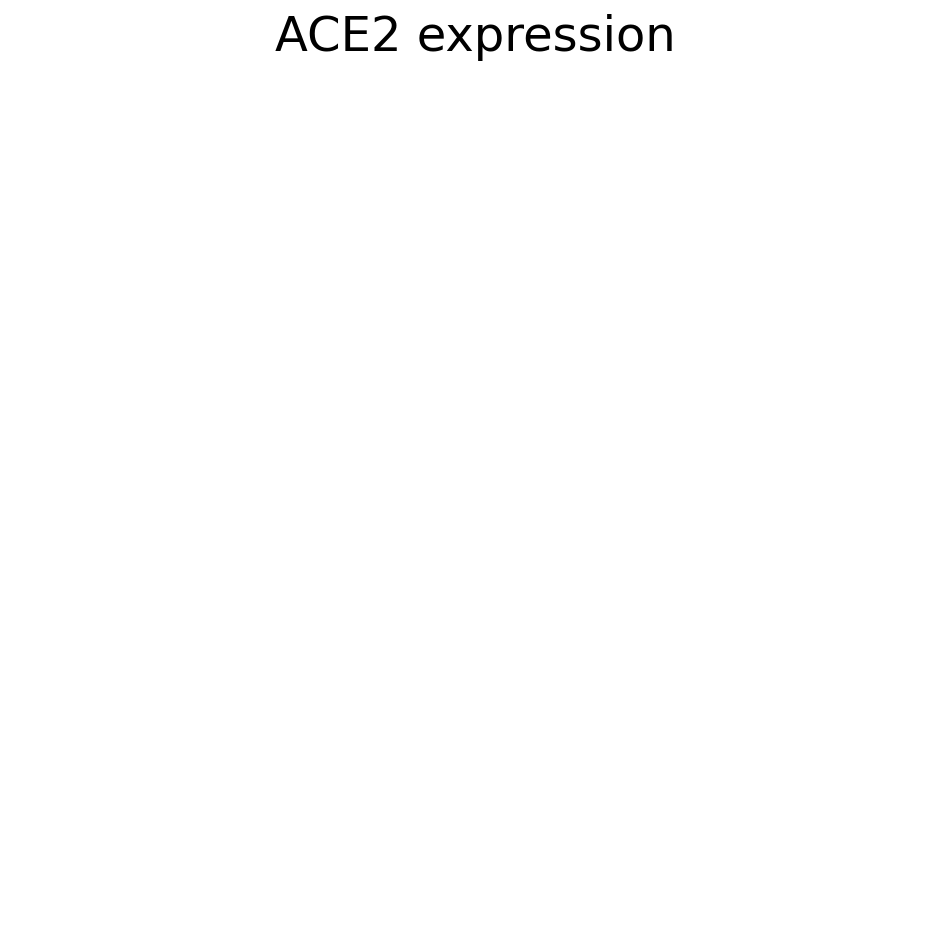

In [ ]:
gene = "ACE2"

fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_nca_tsne"][:,0]
y = data.obsm["X_nca_tsne"][:,1]
c = nd(data.layers["log1p"].todense()[:,data.var.gene_name==gene])

ax.scatter(x, y, c = c, cmap='Reds', alpha=0.5)

ax.set_axis_off()
ax.set_title("{} expression".format(gene))
plt.tight_layout()
plt.show()

In [ ]:
"ACE2" in data.var["gene_name"] 

False

It looks like ACE2 is not present in our filtered matrix. This means it was filtered out during one of our quality control steps.

In [ ]:
adata.var.loc[adata.var["gene_name"] == "ACE2"]

,gene_id,gene_name,gene_counts,n_cells,pass_gene_filter
gene_name,,,,,
ACE2,ENSG00000130234.10,ACE2,0.0,0,False


Indeed, there was not a single count from ACE2 in any cell as quantified by kb.